# Idea is to compare runs of cue with all lines, no low-ionization lines, and no argon and sulfur lines in here

what to compare:

    predictions of [S II], [O I], [S III], [Ar IIII]

In [1]:
import numpy as np
import dill as pickle
import matplotlib
import corner
from matplotlib import pyplot as plt
from pkg_resources import resource_filename
import cue
from cue.line import predict
from cue.utils import (c, cont_lam, new_sorted_line_name, 
                       logQ, Qtotal,
                       get_loglinear_spectra, ionparam2norm, calcQ) # this includes some constants and functions for the fits and output plots

/tmp/ipykernel_3665113/3554174639.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
2025-11-06 13:06:11.190857: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-06 13:06:11.191187: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 13:06:11.229710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 

In [2]:
# first: we have to readin the galaxy observed lines
galaxy = "fBM40"
with open("line_luminosities/"+galaxy+".pkl", 'rb') as f:
    obs = pickle.load(f)
obs.keys()

wav_ind, = np.where((obs['line_lum']!=0) | (obs['line_lum_up']!=0))
wav_ind_obs, = np.where(obs['line_lum']!=0)  # indices where line is observed
wav_ind_up, = np.where(obs['line_lum_up']!=0)

# S/N of the observation
SN_obs = np.zeros_like(obs['line_lum'])
SN_obs[wav_ind_obs] = obs['line_lum'][wav_ind_obs]/obs['line_lum_unc'][wav_ind_obs] 
SN_obs[wav_ind_up] = 3

# S/N of the emulator test data set, here the noise is the emulator uncertainty
with open(resource_filename("cue", "data/nn_stats_v0.pkl"), 'rb') as f:
       nn_stats = pickle.load(f)
SN_nn = nn_stats['SN_quantile'][1][np.argsort(nn_stats['wav'])]

# combine the observed SN and the emulator SN to estimate the noise for the measured lines
SN_obs[wav_ind_obs] = 1./np.sqrt(1./SN_obs[wav_ind_obs]**2 + 1./SN_nn[wav_ind_obs]**2)
line_noise = np.zeros_like(obs['line_lum'])
line_noise[wav_ind_obs] = (obs['line_lum'][wav_ind_obs]/SN_obs[wav_ind_obs])
line_noise[wav_ind_up] = obs['line_lum_unc'][wav_ind_up]
line_var = line_noise**2

/tmp/ipykernel_3665113/2619571391.py:13: RuntimeWarning: divide by zero encountered in divide
  SN_obs[wav_ind_obs] = obs['line_lum'][wav_ind_obs]/obs['line_lum_unc'][wav_ind_obs]


In [3]:
results_file = "cue-results/"+galaxy+"_results_full_lines_stellar.pkl"
with open(results_file, 'rb') as f:
    cue_results = pickle.load(f)
cue_results.keys()

['niter',
 'ncall',
 'eff',
 'samples',
 'samples_id',
 'samples_batch',
 'samples_it',
 'samples_u',
 'samples_n',
 'logwt',
 'logl',
 'logvol',
 'logz',
 'batch_nlive',
 'batch_logl_bounds',
 'blob',
 'proposal_stats',
 'logzerr',
 'information',
 'bound',
 'bound_iter',
 'samples_bound',
 'scale']

# KDE for best-fit

In [4]:
# get gaussian kde
from scipy.stats import gaussian_kde
from scipy import optimize

# kernel = gaussian_kde(cue_results['samples'][:,ion_ind], bw_method="scott")  # default bandwidth is scott
# ion_param = np.arange(-4.0,-1.0, 0.01)
# kde = kernel.evaluate(ion_param)

# opt = optimize.minimize_scalar(lambda x: -kernel(x))  # find maximum of kde
# print(opt.x)

# plt.hist(cue_results['samples'][:,ion_ind], density=True)
# plt.plot(ion_param, kde, color = "black")
# plt.axvline(opt.x, color = "blue", ls = "--")
# plt.xlabel("ionization parameter", fontsize=12)
# plt.ylabel("density", fontsize=12)
# plt.show()

In [5]:
# def get_max_of_posterior_kde(some_cue_results, plot):
#     "input some cue results, returns the max of the kde for a parameter's posterior"
#     max_of_posterior_kdes = []

#     for i in range(len(some_cue_results["samples"][0])): # basically for every parameter
#         n_samples = len(some_cue_results["samples"])
#         kernel = gaussian_kde(some_cue_results['samples'][:,i], bw_method="scott")  # default bandwidth is scott
#         x_range = np.linspace(min(some_cue_results['samples'][:,i]),max(some_cue_results['samples'][:,i]), n_samples)
#         kde = kernel.evaluate(x_range)

#         # find maximum of kde
#         if i == 12:
#             opt = optimize.fmin(lambda x: -kernel(x),50)
#         else:
#             opt_ = optimize.minimize_scalar(lambda x: -kernel(x))
#             opt = opt_.x
          

#         if plot:
#             plt.hist(some_cue_results['samples'][:,i], density=True)
#             plt.plot(x_range, kde, color = "black")
#             plt.axvline(opt, color = "blue", ls = "--")
#             plt.show()
        
#         max_of_posterior_kdes.append(*opt)

#     return max_of_posterior_kdes
        

# kde_max_params = get_max_of_posterior_kde(cue_results, True)

In [6]:
# sigmas = 1 - np.exp(-np.array([1,2,3])**2/2) #corresponding to 1,2,3 sigmas
# labels = [r'$\alpha_\mathrm{HeII}$', r'$\alpha_\mathrm{OII}$', 
#           r'$\alpha_\mathrm{HeI}$', r'$\alpha_\mathrm{HI}$',
#           r'$\log \frac{F_\mathrm{OII}}{F_\mathrm{HeII}}$', 
#           r'$\log \frac{F_\mathrm{HeI}}{F_\mathrm{OII}}$', 
#           r'$\log \frac{F_\mathrm{HI}}{F_\mathrm{HeI}}$',
#           r'$\log U$', r'$\log n_\mathrm{H}$', 
#           r'[O/H]', 
#           r'[N/O]', 
#           r'[C/O]',
#           r'$\log Q_\mathrm{ion}$'
#          ]
# from dynesty.utils import resample_equal
# plot_min, plot_max = np.quantile(resample_equal(cue_results['samples'], 
#                                  np.exp(cue_results['logwt']-cue_results['logz'][-1])), 
#                                  [0, 1], axis=0)
# plot_range = [[np.min([cue_results['samples'][-1][i], plot_min[i]]), 
#                np.max([cue_results['samples'][-1][i], plot_max[i]])] for i in range(len(plot_min))]
# fig = corner.corner(cue_results['samples'],
#                     bins = 20,
#                     weights=np.exp(cue_results['logwt']-cue_results['logz'][-1]),
#                     truths = cue_results['samples'][-1],   # "truth" is just the last run?
#                     truth_color= 'k',
#                     #title_quantiles = [0.025, 0.5, 0.975],
#                     quantiles = [0.16, 0.5, 0.84], #[0.025, 0.5, 0.975],
#                     #verbose = True,
#                     color='#4682b4', 
#                     show_titles=True, 
#                     title_kwargs={"fontsize": 25}, 
#                     label_kwargs={"size":25}, 
#                     #max_n_ticks=7, 
#                     range = plot_range,
#                     alpha=0.6,
#                     levels=sigmas, 
#                     plot_datapoints=False,
#                     plot_density=False,
#                     fill_contours=True,
#                    )
# [ax.tick_params(labelsize=15) for ax in fig.get_axes()]
# axes = np.array(fig.axes).reshape((len(cue_results['samples'][-1]), 
#                             len(cue_results['samples'][-1])))
# for i in range(12):
#     axes[i+1, 0].set_ylabel(labels[i+1], size=25)
# for i in range(13):
#     axes[-1, i].set_xlabel(labels[i], size=25)

# plt.show()

# Getting line predictions from best-fit

In [7]:
# goodness of fit function for emission lines. 
# The noise here is only the observational noise, different than the one in likelihood function, where we also account for the emulator noise.
def chi_lines(fit, observed_galaxy):
    "takes in a fit, like low_line or med_line, and calculates the chi for predicted - observed"
    chi = np.zeros_like(observed_galaxy["line_lum"])
    chi[wav_ind_obs] = (fit[wav_ind_obs]-observed_galaxy["line_lum"][wav_ind_obs]) / observed_galaxy["line_lum_unc"][wav_ind_obs]
    chi[wav_ind_up] = (fit[wav_ind_up]-0) / observed_galaxy["line_lum_unc"][wav_ind_up]
    
    chisq = np.sum(chi**2)
    ndof = len(chi[wav_ind])
    reduced_chisq = chisq/(ndof)

    percent_diff = np.zeros_like(observed_galaxy["line_lum"])
    percent_diff[wav_ind_obs] = (fit[wav_ind_obs]-observed_galaxy["line_lum"][wav_ind_obs]) / obs["line_lum"][wav_ind_obs]

    return reduced_chisq, chi, percent_diff

# define line labels of the emission lines for the plots

def formatNumber(num):
    if num % 1 == 0:
        return str(int(num))
    else:
        return str(num)

In [ ]:
round_to_n = lambda x, n: x if x == 0 else round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))
# just formatting the x labels
shortened_sorted_line_name = list()
for i in range(len(new_sorted_line_name)):
    new_name = new_sorted_line_name[i][:5] + \
    formatNumber(round_to_n(float(new_sorted_line_name[i][5:12]), 4)) + \
    new_sorted_line_name[i][12]
    if new_name[-1] == 'A':
        new_name = new_name[:-1] + r'$\mathrm{\AA}$'
    if new_name[-1] == 'm':
        new_name = new_name[:-1] + r'$\mathrm{\mu}$m'
    shortened_sorted_line_name.append(new_name)
shortened_sorted_line_name = np.array(shortened_sorted_line_name)

# these are the lines we want to plot the predictions for
lines_of_interest =  ['Ar 3 3109.18A', 'S  3 3721.63A', 'O  2 3726.03A', 'O  2 3728.81A',
                        'S  2 4068.60A', 'S  2 4076.35A', 'Ar 4 4711.26A', 'Ar 4 4740.12A', 
                        'O  3 4958.91A', 'O  3 5006.84A',
                        'Ar 3 5191.82A', 
                    "O  1 6300.30A", 'S  3 6312.06A', 
                    'O  1 6363.78A', 'N  2 6548.05A', 'H  1 6562.80A', 'N  2 6583.45A',
                    "S  2 6716.44A", "S  2 6730.82A", 
                    'Ar 3 7135.79A', 'Ar 4 7332.15A', 'Ar 3 7751.11A', 
                    "S  3 9068.62A", "S  3 9530.62A", "S  2 1.03364m"] 

inds_of_interest = [i for i in range(len(obs['line_name'])) if obs['line_name'][i] in lines_of_interest]


In [ ]:
def get_linepredictions_forarun(galaxy, endtag, plot):
    with open("cue-results/"+galaxy+"_results_"+endtag+"_stellar.pkl", 'rb') as f:
        cue_results = pickle.load(f)
    cue_results.keys()

    with open("line_luminosities/"+galaxy+".pkl", 'rb') as f:
        obs_gal = pickle.load(f)
    obs_gal.keys()


    # median and 1-sigma range of the emission line and nebular continuum
    from dynesty.utils import resample_equal
    theta_arr = resample_equal(cue_results.samples, np.exp(cue_results.logwt-cue_results.logz[-1]), rstate=None) 
                                 # resamples a set of points from the weighted set of inputs such that they all have equal weight

    line_pred = list()
    cont_pred = list()
    for ind in range(len(theta_arr)):
        # for literally every chain, 
        par = theta_arr[ind].copy()
        par[7] = logQ(par[7], lognH=par[8])
        par[8] = 10**par[8]
        line_pred.append(predict(theta=np.array(par[:12]).reshape(1, 12), 
                                line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12])     # based on the parameters in the theta array, predict lines
        cont_pred.append(cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/\
        10**par[7]*10**par[12])

        
    low_line, med_line, up_line = np.quantile(np.array(line_pred), [0.16, 0.5, 0.84], axis=0)  # gets the 16% probability, median, and 84% probability
    low_cont, med_cont, up_cont = np.quantile(np.array(cont_pred), [0.16, 0.5, 0.84], axis=0)

    "Comparing the line flux predictions from the emulator to the observed lines"
    line_preds_of_interest = [i[inds_of_interest] for i in line_pred]


    linechi_low = chi_lines(low_line, obs_gal)[1]
    linechi_up = chi_lines(up_line, obs_gal)[1]
    linechi_med = chi_lines(med_line, obs_gal)[1]      # gets the chi of the median predicted value of all the lines, basically 

    #best_line_chi = chi_lines(best_line_pred)[1]
    #newu_line_chi = chi_lines(newu_line_pred)[1]
    chi_preds = [chi_lines(i, obs_gal)[1] for i in line_pred]
    chi_preds_of_interest = [i[inds_of_interest] for i in chi_preds]

    percentdiffs_distribution = [chi_lines(i, obs_gal)[2] for i in line_pred]
    percentdiffs_of_interest = [i[inds_of_interest] for i in percentdiffs_distribution]
    percentdiff_low = chi_lines(low_line, obs_gal)[2]
    percentdiff_up = chi_lines(up_line, obs_gal)[2]
    percentdiff_med = chi_lines(med_line, obs_gal)[2]

    # for i in inds_of_interest:
    #     print(lines_of_interest[i], "chi of the median line prediction compared to the observation",linechi_med[i], "uncertainty on line", obs["line_lum_unc"][i])


    return shortened_sorted_line_name[inds_of_interest], linechi_med[inds_of_interest], linechi_low[inds_of_interest], linechi_up[inds_of_interest], line_preds_of_interest, chi_preds_of_interest,  \
           med_line[inds_of_interest], percentdiff_med[inds_of_interest], percentdiff_low[inds_of_interest], percentdiff_up[inds_of_interest], percentdiffs_of_interest, \
            obs_gal


In [9]:
line_names, linechi_med, linechi_low, linechi_up,  line_preds, all_chis, med_line, percentdiffs_med, percentdiffs_low, percentdiffs_up, percentdiffs = get_linepredictions_forarun("cue-results/"+galaxy+"_results_nolowion_noarsulf_stellar.pkl", False)

TypeError: get_linepredictions_forarun() missing 1 required positional argument: 'plot'

In [ ]:
line_names_full, linechi_med_full, linechi_low_full, linechi_up_full,  line_preds_full, all_chis_full, med_line_full, percentdiffs_med_full, percentdiffs_low_full, percentdiffs_up_full, percentdiffs_full = get_linepredictions_forarun("cue-results/"+galaxy+"_results_full_lines_stellar.pkl", plot=False)

/tmp/ipykernel_3550036/2129854397.py:6: RuntimeWarning: divide by zero encountered in divide
  chi[wav_ind_obs] = (fit[wav_ind_obs]-obs["line_lum"][wav_ind_obs]) / obs["line_lum_unc"][wav_ind_obs]


In [10]:
plt.figure(figsize=(10,5))
plt.errorbar(line_names, percentdiffs_med,
                           yerr=[percentdiffs_med-percentdiffs_low, percentdiffs_up-percentdiffs_med],
                           color='blue', marker='s', markersize=7, linestyle=' ', 
                           markeredgecolor='k', alpha=0.5, capsize=4,label = "no low-ionization or ar, sulf in fit, median")
plt.errorbar(line_names_full, percentdiffs_med_full,
                           yerr=[np.abs(percentdiffs_med_full-percentdiffs_low_full), np.abs(percentdiffs_up_full-percentdiffs_med_full)],
                           color='tab:orange', marker='s', markersize=7, linestyle=' ', 
                           markeredgecolor='k', alpha=0.5, capsize=4,label = "all lines considered in fit, best line")
plt.ylabel('fit - obs)/obs');
plt.xticks(rotation=90)
plt.legend()
#plt.ylim(-25,100)
plt.show()

NameError: name 'line_names' is not defined

<Figure size 1000x500 with 0 Axes>

In [11]:
lines_of_interest =  ['Ar 3 3109.18A', 'S  3 3721.63A', 'O  2 3726.03A', 'O  2 3728.81A',
                        'S  2 4068.60A', 'S  2 4076.35A', 'Ar 4 4711.26A', 'Ar 4 4740.12A', 
                        'O  3 4958.91A', 'O  3 5006.84A',
                        'Ar 3 5191.82A', 
                    "O  1 6300.30A", 'S  3 6312.06A', 
                    'O  1 6363.78A', 'N  2 6548.05A', 'H  1 6562.80A', 'N  2 6583.45A',
                    "S  2 6716.44A", "S  2 6730.82A", 
                    'Ar 3 7135.79A', 'Ar 4 7332.15A', 'Ar 3 7751.11A', 
                    "S  3 9068.62A", "S  3 9530.62A", "S  2 1.03364m"] 

inds_of_interest = [i for i in range(len(obs['line_name'])) if obs['line_name'][i] in lines_of_interest]

NameError: name 'line_names_full' is not defined

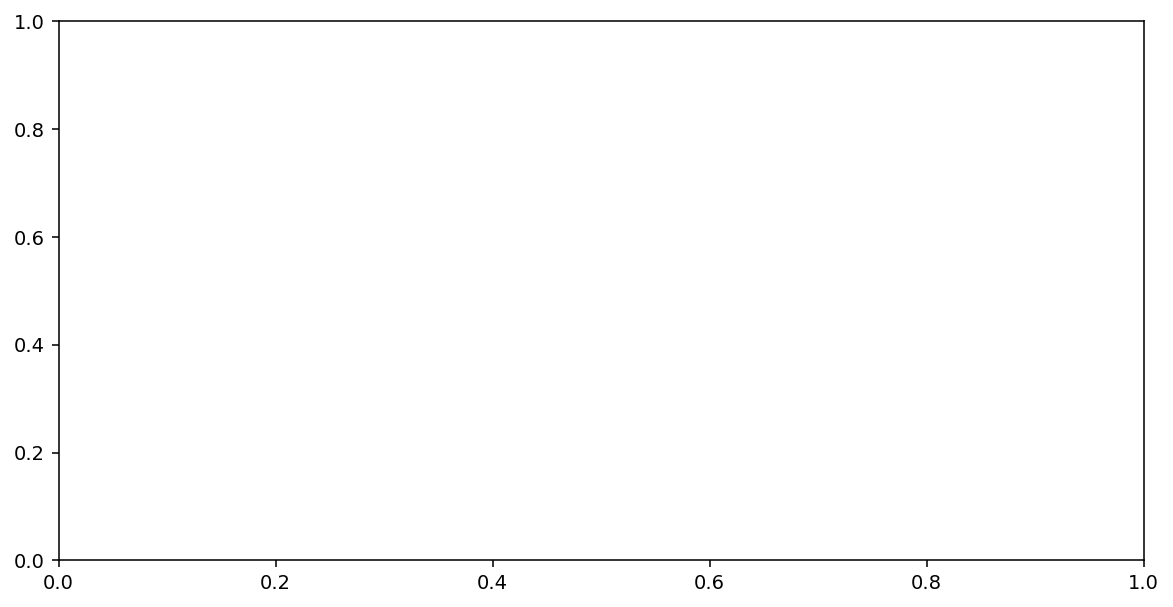

In [12]:
fig, (line_lum_ax) = plt.subplots(1, 1, #sharex=True, 
                                            figsize=(10,5.), dpi=140)

line_lum_ax.errorbar(line_names_full, obs["line_lum"][inds_of_interest], yerr=obs["line_lum_unc"][inds_of_interest],
    marker='d', ls=' ', color='green', markeredgecolor='k', alpha=0.5,
    label="obs")
line_lum_ax.scatter(line_names_full, med_line_full,
                    marker='o', color='C1', edgecolor='k', alpha=0.6,
                    label="Cue, full lines")
line_lum_ax.scatter(line_names, med_line,
                    marker='o', color='tab:blue', edgecolor='k', alpha=0.6,
                    label="Cue, min lines")
line_lum_ax.legend(framealpha=0., handletextpad=0.08, labelspacing=0.05, 
                   ncol=2, columnspacing=1.5, handlelength=1.0, 
                   loc='upper center', bbox_to_anchor=(0.42, 1.02)); 
line_lum_ax.set_ylabel(r'L (erg/s)')
line_lum_ax.set_yscale('log')
line_lum_ax.set_ylim(line_lum_ax.get_ylim()[0]*0.92, line_lum_ax.get_ylim()[1]*2)
line_lum_ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
plt.xticks(rotation=90);

In [13]:
for ind in range(len(inds_of_interest)):
     print("\n",lines_of_interest[ind], obs["line_lum"][inds_of_interest[ind]], med_line[ind])
     print((med_line[ind] - obs["line_lum"][inds_of_interest[ind]])/obs["line_lum"][inds_of_interest[ind]])
     print(linechi_med[ind])

NameError: name 'med_line' is not defined

there is something wrong with linechi_med.....
ah... maybe because it's getting the distribution of chis, then getting the median for that? no...

# Making violin plots

In [16]:
print(np.array(line_preds).shape)
# line_preds = np.array(line_preds)
# all_chis = np.array(all_chis)
# line_preds is an array with predictions of now just the 25 lines for the 22316 parameter combos
lines_of_interest =  ['Ar 3 3109.18A', 'S  3 3721.63A', 'O  2 3726.03A', 'O  2 3728.81A',
                          'S  2 4068.60A', 'S  2 4076.35A', 'Ar 4 4711.26A', 'Ar 4 4740.12A', 
                          'O  3 4958.91A', 'O  3 5006.84A',
                          'Ar 3 5191.82A', 
                      "O  1 6300.30A", 'S  3 6312.06A', 
                      'O  1 6363.78A', 'N  2 6548.05A', 'H  1 6562.80A', 'N  2 6583.45A',
                      "S  2 6716.44A", "S  2 6730.82A", 
                      'Ar 3 7135.79A', 'Ar 4 7332.15A', 'Ar 3 7751.11A', 
                      "S  3 9068.62A", "S  3 9530.62A", "S  2 1.03364m"] 

NameError: name 'line_preds' is not defined

In [17]:
# plt.hist(line_preds[:,22], bins = 200)
# plt.show()
# for i in wav_ind_obs:
#     print(obs["line_name"][i], obs["line_lum"][i])

In [18]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel('Sample name')

# create test data
# data = line_preds

# fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), sharey=True)
# ax.set_title('Customized violin plot')
# parts = ax.violinplot(
#         data, showmeans=False, showmedians=False,
#         showextrema=False)

# for pc in parts['bodies']:
#     pc.set_facecolor('#D43F3A')
#     pc.set_edgecolor('black')
#     pc.set_alpha(1)

# quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
# whiskers = np.array([
#     adjacent_values(sorted_array, q1, q3)
#     for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
# whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

# inds = np.arange(1, len(medians) + 1)
# ax.scatter(inds, medians, marker='o', color='grey', s=30, zorder=3)
# ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
# ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# # set style for the axes
# labels = lines_of_interest
# set_axis_style(ax, labels)
# plt.xticks(rotation=90)
# plt.subplots_adjust(bottom=0.15, wspace=0.05)
# plt.ylabel("predicted line luminosity")
# plt.show()

In [19]:
def plot_violin_and_distribution(ind, ax1, ax2, chosen_distribution):

    line_prediction, line_label = chosen_distribution[:,ind], [lines_of_interest[ind]]

    ax1.violinplot(line_prediction)
    quartile1, medians, quartile3 = np.percentile(line_prediction, [25, 50, 75], axis=0)
    inds = np.arange(1, len(line_label) + 1)
    ax1.scatter(inds, medians, marker='s', color='white', s=50, zorder=3)
    ax1.annotate(np.round(medians,2), (inds, medians),  xytext = (inds+0.02, medians), color='black',  zorder=3)
    ax1.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax1.set_xticks(np.arange(1, len(line_label) + 1), labels=line_label)

    n_samples = len(line_prediction)
    kernel = gaussian_kde(line_prediction, bw_method="scott")  # default bandwidth is scott
    x_range = np.linspace(min(line_prediction),max(line_prediction), n_samples)
    kde = kernel.evaluate(x_range)
    #opt = optimize.minimize_scalar(lambda x: -kernel(x))

    ax2.hist(line_prediction, density=True, alpha = 0.5)
    ax2.plot(x_range, kde, color = "black")
    #ax2.axvline(opt.x, color = "black", label = "max of KDE")
    ax2.axvline(medians, color = "grey", label = "median")
    #ax2.annotate(np.round(*opt.x,2), (opt.x, 0.01))
    ax2.annotate(np.round(medians,2), (medians, 0.02))


distribution = np.array(percentdiffs)
fig, ((ax0, ax1, ax2, ax3, ax4), (ax02,ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=5, figsize=(20,12), sharey = "row")
plot_violin_and_distribution(11, ax0, ax02, distribution)
plot_violin_and_distribution(17, ax1, ax5, distribution)
plot_violin_and_distribution(18, ax2, ax6, distribution)
#plot_violin_and_distribution(22, ax3, ax7, distribution)
plot_violin_and_distribution(23, ax4, ax8, distribution)
plt.subplots_adjust(bottom=0.15, wspace=0.05)
ax0.set_ylabel(r"fit - obs/obs",fontsize=14)
ax02.set_ylabel("N")
ax5.legend()
plt.show()

NameError: name 'percentdiffs' is not defined

fbm40 should have s3 in g235m?????? so why is 9069 not shown here

## Delta s2 and o1 for all cecilia galaxies

In [20]:
galaxy_names = ["BX216", "BX274", "BX336", "BX341", "BX348", "BX350", "BX390", "BX418", "BX429", "BX461", "BX474", "BX523", "BX587", "BX628", "D40", "fBM40", "fBM47", "fC23", "MD41"]

In [ ]:
percentdiffs_all_galaxies = []
for galaxy in galaxy_names:
    line_names, linechi_med, linechi_low, linechi_up,  line_preds, all_chis, med_line, percentdiffs_med, percentdiffs_low, percentdiffs_up, percentdiffs = get_linepredictions_forarun(galaxy, "nolowion_noarsulf", False)
    
    percentdiffs_all_galaxies.append(percentdiffs)

/tmp/ipykernel_3665113/1606293938.py:6: RuntimeWarning: divide by zero encountered in divide
  chi[wav_ind_obs] = (fit[wav_ind_obs]-observed_galaxy["line_lum"][wav_ind_obs]) / observed_galaxy["line_lum_unc"][wav_ind_obs]


In [22]:
def get_distribution_anyline(distribution, line_ind):
    "get the median and max density chi for any lines for some input cecilia galaxy"
    distribution = np.array(distribution)

    line_distribution, line_label = distribution[:,line_ind], lines_of_interest[line_ind]
    quartile1, median, quartile3 = np.percentile(line_distribution, [25, 50, 75], axis=0)

    # plt.hist(line_prediction, density = True)
    # plt.show()

    #kernel = gaussian_kde(line_distribution, bw_method="scott")  # default bandwidth is scott

    # n_samples = len(line_prediction)
    # x_range = np.linspace(min(line_prediction),max(line_prediction), n_samples)
    # kde = kernel.evaluate(x_range)

    
    # plt.plot(x_range, kde)
    # plt.show()
    # opt = optimize.minimize_scalar(lambda x: -kernel(x))

    return line_distribution, np.float64(median), np.float64(quartile1), np.float64(quartile3)  #, *opt.x
inds_of_interest = [2,3,8,9,11,17,18,22,23]
line_labels= [lines_of_interest[ind] for ind in inds_of_interest]
o2_3727_all_galaxies = [get_distribution_anyline(chi_dist, 2) for chi_dist in percentdiffs_all_galaxies]
o2_3729_all_galaxies = [get_distribution_anyline(chi_dist, 3) for chi_dist in percentdiffs_all_galaxies]
o3_4959_all_galaxies = [get_distribution_anyline(chi_dist, 8) for chi_dist in percentdiffs_all_galaxies]
o3_5007_all_galaxies = [get_distribution_anyline(chi_dist, 9) for chi_dist in percentdiffs_all_galaxies]
o1_6300_all_galaxies = [get_distribution_anyline(chi_dist, 11) for chi_dist in percentdiffs_all_galaxies]
s2_6717_all_galaxies = [get_distribution_anyline(chi_dist, 17) for chi_dist in percentdiffs_all_galaxies]
s2_6731_all_galaxies = [get_distribution_anyline(chi_dist, 18) for chi_dist in percentdiffs_all_galaxies]
s3_9069_all_galaxies = [get_distribution_anyline(chi_dist, 22) for chi_dist in percentdiffs_all_galaxies]
s3_9531_all_galaxies = [get_distribution_anyline(chi_dist, 23) for chi_dist in percentdiffs_all_galaxies]


In [ ]:
print(np.array(percentdiffs_all_galaxies[0])[:,])

In [23]:
print(o3_4959_all_galaxies)

[(array([0., 0., 0., ..., 0., 0., 0.], shape=(21775,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(17701,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(23981,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(21633,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(17976,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(21211,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(14546,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(18018,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.], shape=(21717,)), np.float64(0.0), np.float64(0.0), np.float64(0.0)), (array([0., 0., 0., ..., 0., 0., 0.]

o3 4950 and 5007 chi distributions are the same...


In [27]:
name_inds = np.arange(len(galaxy_names))

In [28]:
def plot_all_violins(list_for_some_line, line_name):
    "this function is so messed up lol, fix at some point"
    line_pred = [i[0] for i in list_for_some_line]
    meds = [i[1] for i in list_for_some_line]
    q1 = [i[2] for i in list_for_some_line]
    q3 = [i[3] for i in list_for_some_line]

    plt.figure(figsize=(12,4))
    plt.violinplot(line_pred)
    plt.scatter(name_inds+1, meds, marker = "s", zorder=5, color="tab:blue")
    plt.vlines(name_inds+1, q1, q3, color='black', linestyle='-', lw=2)
    plt.xticks(name_inds+1, labels=galaxy_names, rotation=90)
    plt.ylabel(line_name, fontsize=15)
    plt.ylim(min(q1)-(abs(min(q1))/2), max(q3)+(max(q3)/2))
    #plt.ylim(-10,60)
    plt.show()

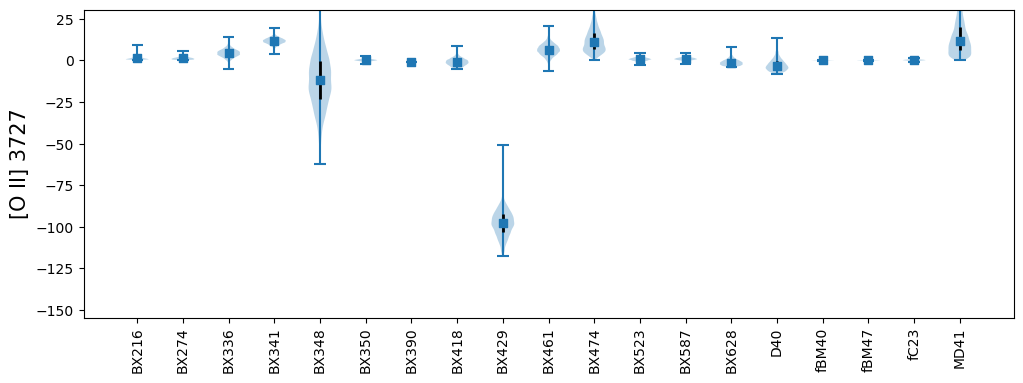

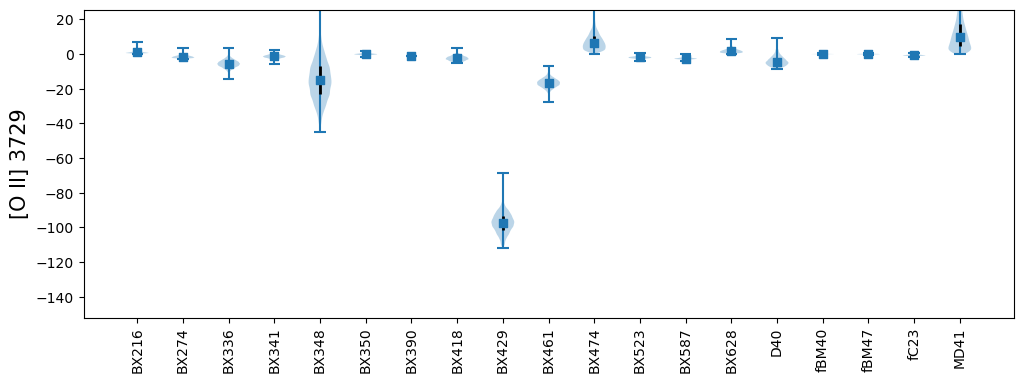

/tmp/ipykernel_3665113/2232834726.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min(q1)-(abs(min(q1))/2), max(q3)+(max(q3)/2))


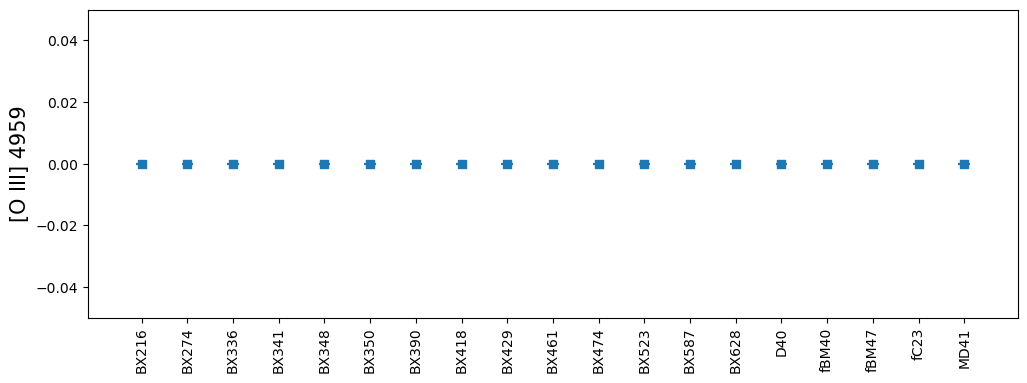

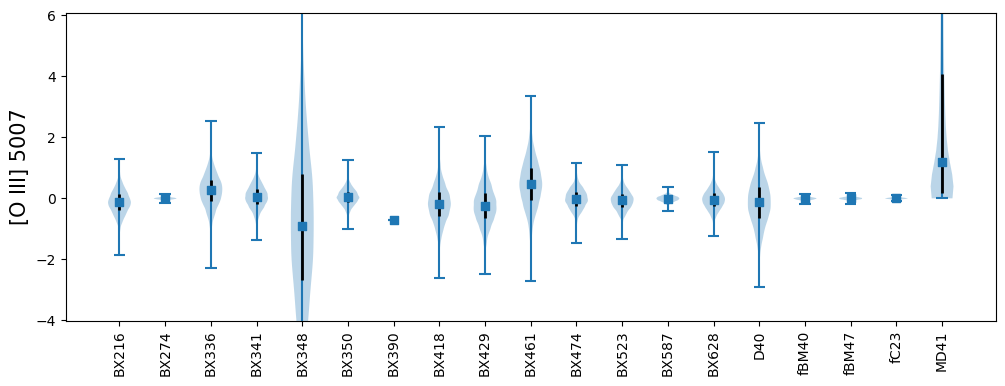

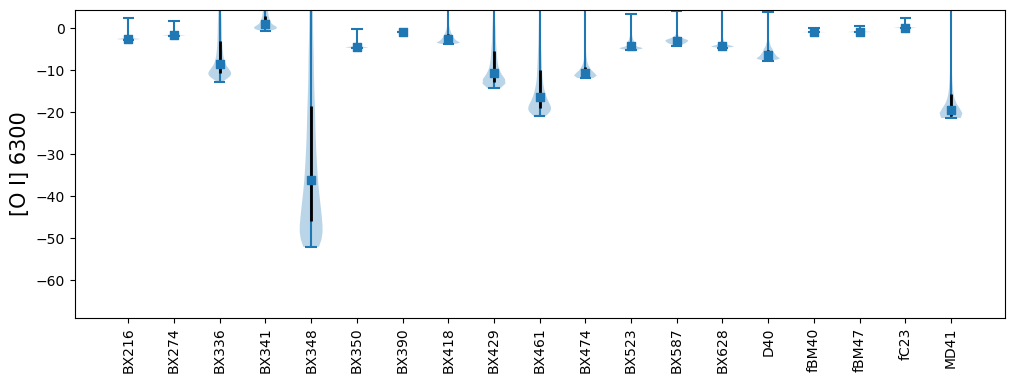

In [29]:
plot_all_violins(o2_3727_all_galaxies, "[O II] 3727")
plot_all_violins(o2_3729_all_galaxies, "[O II] 3729")
plot_all_violins(o3_4959_all_galaxies, "[O III] 4959")
plot_all_violins(o3_5007_all_galaxies, "[O III] 5007")
plot_all_violins(o1_6300_all_galaxies, "[O I] 6300")

wtf is up with 4959 and 9069????????? some of these galaxies have to have 4959 and 9069...

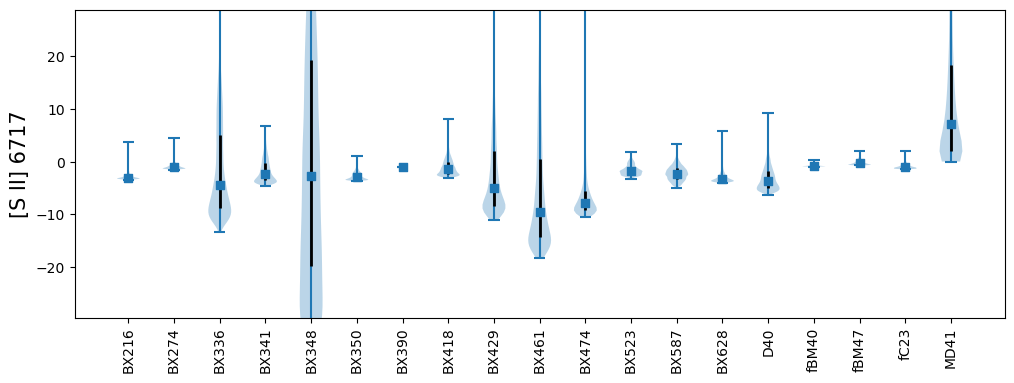

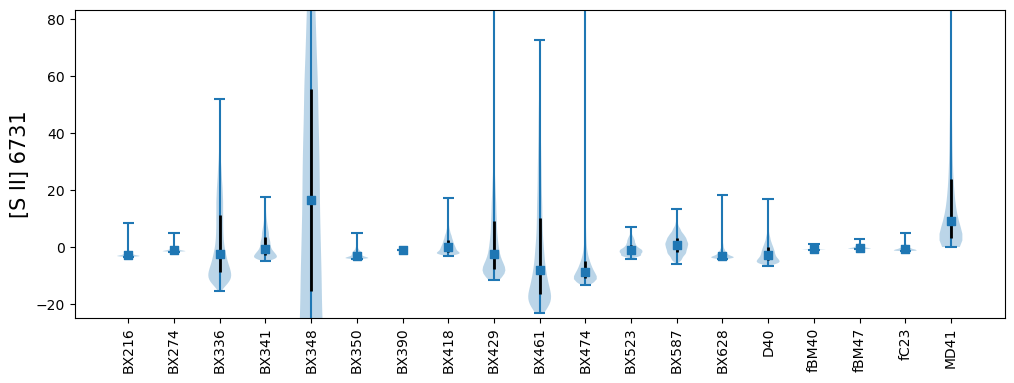

/tmp/ipykernel_3665113/2232834726.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min(q1)-(abs(min(q1))/2), max(q3)+(max(q3)/2))


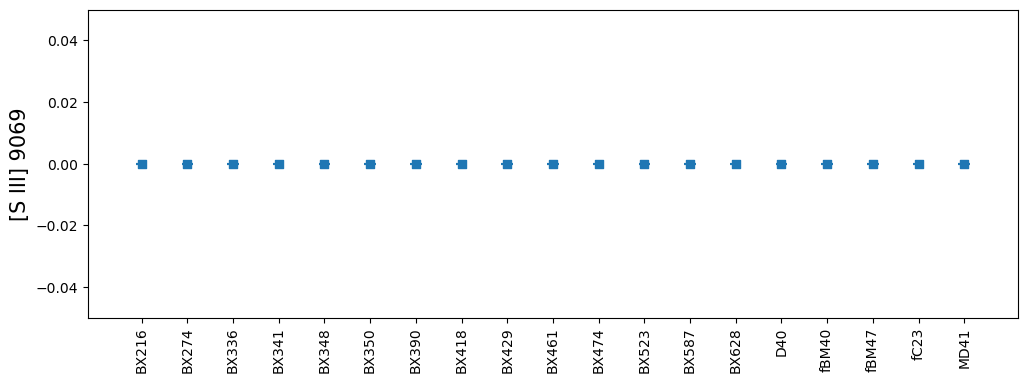

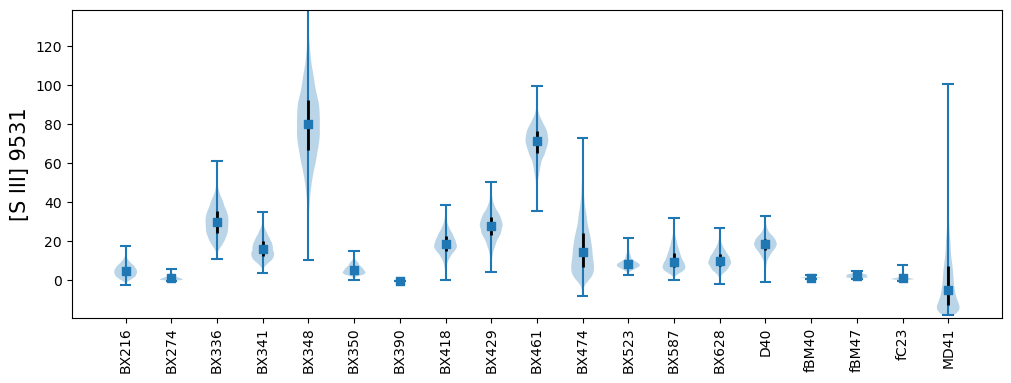

In [30]:
plot_all_violins(s2_6717_all_galaxies, "[S II] 6717")
plot_all_violins(s2_6731_all_galaxies, "[S II] 6731")
plot_all_violins(s3_9069_all_galaxies, "[S III] 9069")
plot_all_violins(s3_9531_all_galaxies, "[S III] 9531")